# Whole genome sequencing data analysis for *C. necator*

## 분석 환경 구축 및 자료 준비

In [1]:
# 가상환경 구축
#### conda create -n breseq2 #'breseq2'=가상환경 이름
#### conda activate breseq2

## 패키지 인스톨
#### conda install -c conda-forge gzip
#### conda install -c bioconda trim-galore
#### conda install -c bioconda breseq
#### conda install -c conda-forge r-base
#### pip install jupyter notebook
#### pip install pandas
#### pip install openpyxl
#### pip install xlsxwriter

# 엑셀 데이터 분석을 위한 패키지 불러오기
import openpyxl
import xlsxwriter
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib_venn
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from venn import venn


# 현재 경로 확인
os.getcwd()

'/Users/jiwonkim/Library/CloudStorage/OneDrive-개인/YL_bioinformatics/NGS-SJ'

In [2]:
## 분석자료 준비

## genome 파일, 시퀀싱 파일, 주피터 노트북 파일을 한 폴더로 이동시키고, 경로를 설정
# cd /Users/jiwonkim/Downloads

## 시퀀싱 데이터 퀄리티 확인
# gunzip RXI_1.fastq.gz
# trim_galore -o ./trimming RXI_1.fastq --paired --fastqc --illumina 
# 결과로 나오는 RXI_1_val.fq 파일을 앞으로 사용함

## Annotated reference genome data 확인
# Cupriavidus necator H16: https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_004798725.1/
# reference genome: GCA_004798725.1_ASM479872v1_genome.gbff 이름으로 저장

## NGS 데이터 분석

In [3]:
## breseq 러닝

## breseq -j 8 -p -r GCA_004798725.1_ASM479872v1_genome.gbff RXI_1_val_1.fq RXI_2_val_2.fq -o breseq_output_RXI
# -j 8 : threads number=8
# -r GCA_004798725.1_ASM479872v1_genome.gbff.gbff : 
#     reference genome이 GCA_004798725.1_ASM479872v1_genome.gbff.gbff라고 알림
# -o breseq_output_RXI : 결과 파일이 breseq_output_RXI 폴더에 저장되도록 지시

## 결과 정리 및 specific mutation 확인

### RXI vs RXI22 (evolved) NGS 결과 해석

In [4]:
# 엑셀 파일 불러오기
excel_file = "RXI_results_merged.xlsx"

# 엑셀 파일로 데이터프레임 생성
df1 = pd.read_excel(excel_file, sheet_name='RXI_raw')

# 데이터프레임 안에서 열 내용 합치고 순서 변경
df1['position'] = df1['position'].astype(str)
df1['seq_id'] = df1['seq_id'].astype(str)
df1['seq_id_position'] = df1['seq_id'] + '_' + df1['position']
df1 = df1.drop(['seq_id', 'position'], axis=1)
new_order = ['evidence', 'seq_id_position', 'freq', 'mutation', 'annotation', 'gene', 'description']
df1 = df1[new_order]
#print(df1)

# 특정 freq 이상을 가지는 값만 필터링
filtered_df_RXI = df1[(df1['freq'] >= 0.8)]
#print(filtered_df_RXI)

# 엑셀에 필터링된 값 재입력
with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    filtered_df_RXI.to_excel(writer, sheet_name='RXI_freq_0.8', index=False)

In [5]:
# 엑셀 파일로 데이터프레임 생성
df2 = pd.read_excel(excel_file, sheet_name='RXI22_raw')

# 데이터프레임 안에서 열 내용 합치고 순서 변경
df2['position'] = df2['position'].astype(str)
df2['seq_id'] = df2['seq_id'].astype(str)
df2['seq_id_position'] = df2['seq_id'] + '_' + df2['position']
df2 = df2.drop(['seq_id', 'position'], axis=1)
new_order = ['evidence', 'seq_id_position', 'freq', 'mutation', 'annotation', 'gene', 'description']
df2 = df2[new_order]
#print(df2)

# 특정 freq 이상을 가지는 값만 필터링
filtered_df_RXI22 = df2[(df2['freq'] >= 0.8)]
#print(filtered_df_RXI22)

# 엑셀에 필터링된 값 재입력
with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    filtered_df_RXI22.to_excel(writer, sheet_name='RXI22_freq_0.8', index=False)

In [6]:
# 전체 mutation 개수 확인
print(len(df1))
print(len(df2))

# frequency 0.8 이상의 mutation 개수 확인
print(len(filtered_df_RXI))
print(len(filtered_df_RXI22))

1105
1284
35
39


In [7]:
# 필터링된 RXI와 RXI22 데이터프레임 병합
merged_df_RXI = pd.merge(filtered_df_RXI, filtered_df_RXI22, on=['seq_id_position'], how='outer', indicator=True)
#print (merged_df_RXI)

In [8]:
#각 그룹에서의 mutation 개수 확인 
RXI_count = len(merged_df_RXI[merged_df_RXI['_merge'] == 'left_only'])
both_count = len(merged_df_RXI[merged_df_RXI['_merge'] == 'both'])
RXI22_count = len(merged_df_RXI[merged_df_RXI['_merge'] == 'right_only'])

print (RXI_count)
print (both_count)
print (RXI22_count)

0
35
4


In [9]:
# 엑셀에 병합된 데이터프레임 입력
with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    merged_df_RXI.to_excel(writer, sheet_name='merged_RXI', index=False)

In [10]:
# RXI22 specific mutation 확인
RXI22_only_df = merged_df_RXI[merged_df_RXI['_merge'] == 'right_only']
#print(RXI22_only_df)

# 엑셀에 RXI22 specific mutation 입력
with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    RXI22_only_df.to_excel(writer, sheet_name='RXI22_only', index=False)

### RXW vs RXW62 (evolved) NGS 결과 해석

In [11]:
# 엑셀 파일 불러오기
excel_file2 = "RXW_results_merged.xlsx"

# 엑셀 파일로 데이터프레임 생성
df3 = pd.read_excel(excel_file2, sheet_name='RXW_raw')

# 데이터프레임 안에서 열 내용 합치고 순서 변경
df3['position'] = df3['position'].astype(str)
df3['seq_id'] = df3['seq_id'].astype(str)
df3['seq_id_position'] = df3['seq_id'] + '_' + df3['position']
df3 = df3.drop(['seq_id', 'position'], axis=1)
new_order = ['evidence', 'seq_id_position', 'freq', 'mutation', 'annotation', 'gene', 'description']
df3 = df3[new_order]
#print(df3)

# 특정 freq 이상을 가지는 값만 필터링
filtered_df_RXW = df3[(df3['freq'] >= 0.8)]
#print(filtered_df_RXW)

# 엑셀에 필터링된 값 재입력
with pd.ExcelWriter(excel_file2, engine='openpyxl', mode='a') as writer:
    filtered_df_RXW.to_excel(writer, sheet_name='RXW_freq_0.8', index=False)

In [12]:
# 엑셀 파일로 데이터프레임 생성
df4 = pd.read_excel(excel_file2, sheet_name='RXW62_raw')

# 데이터프레임 안에서 열 내용 합치고 순서 변경
df4['position'] = df4['position'].astype(str)
df4['seq_id'] = df4['seq_id'].astype(str)
df4['seq_id_position'] = df4['seq_id'] + '_' + df4['position']
df4 = df4.drop(['seq_id', 'position'], axis=1)
new_order = ['evidence', 'seq_id_position', 'freq', 'mutation', 'annotation', 'gene', 'description']
df4 = df4[new_order]
#print(df4)

# 특정 freq 이상을 가지는 값만 필터링
filtered_df_RXW62 = df4[(df4['freq'] >= 0.8)]
#print(filtered_df_RXW62)

# 엑셀에 필터링된 값 재입력
with pd.ExcelWriter(excel_file2, engine='openpyxl', mode='a') as writer:
    filtered_df_RXW62.to_excel(writer, sheet_name='RXW62_freq_0.8', index=False)

In [13]:
# 전체 mutation 개수 확인
print(len(df3))
print(len(df4))

# frequency 0.8 이상의 mutation 개수 확인
print(len(filtered_df_RXW))
print(len(filtered_df_RXW62))

1169
1148
34
39


In [14]:
# 필터링된 RXI와 RXI22 데이터프레임 병합
merged_df_RXW = pd.merge(filtered_df_RXW, filtered_df_RXW62, on=['seq_id_position'], how='outer', indicator=True)
#print (merged_df_RXW)

In [15]:
#각 그룹에서의 mutation 개수 확인 
RXW_count = len(merged_df_RXW[merged_df_RXW['_merge'] == 'left_only'])
both_count = len(merged_df_RXW[merged_df_RXW['_merge'] == 'both'])
RXW62_count = len(merged_df_RXW[merged_df_RXW['_merge'] == 'right_only'])

print (RXW_count)
print (both_count)
print (RXW62_count)

0
34
5


In [16]:
# 엑셀에 병합된 데이터프레임 입력
with pd.ExcelWriter(excel_file2, engine='openpyxl', mode='a') as writer:
    merged_df_RXW.to_excel(writer, sheet_name='merged_RXW', index=False)

In [17]:
# RXI22 specific mutation 확인
RXW62_only_df = merged_df_RXW[merged_df_RXW['_merge'] == 'right_only']
#print(RXW62_only_df)

# 엑셀에 RXI22 specific mutation 입력
with pd.ExcelWriter(excel_file2, engine='openpyxl', mode='a') as writer:
    RXW62_only_df.to_excel(writer, sheet_name='RXW62_only', index=False)

### RXI22 vs RXW62 NGS 결과 해석

In [18]:
merged_df_22_62 = pd.merge(filtered_df_RXI22, filtered_df_RXW62, on=['seq_id_position'], how='outer', indicator=True)
#print (merged_df_22_62)

In [19]:
RXI22_count = len(merged_df_22_62[merged_df_22_62['_merge'] == 'left_only'])
both_count = len(merged_df_22_62[merged_df_22_62['_merge'] == 'both'])
RXW62_count = len(merged_df_22_62[merged_df_22_62['_merge'] == 'right_only'])

print (RXI22_count)
print (both_count)
print (RXW62_count)

3
36
3


In [20]:
merged_df_22_62.to_excel('RXI22_RXW62_mutations.xlsx', sheet_name='RXI22_RXW62_mutations')

excel_file3 = "RXI22_RXW62_mutations.xlsx"

both_22_62_df = merged_df_22_62[merged_df_22_62['_merge'] == 'both']
RXI22only_df = merged_df_22_62[merged_df_22_62['_merge'] == 'left_only']
RXW62only_df = merged_df_22_62[merged_df_22_62['_merge'] == 'right_only']
#print(both_22_62_df)

with pd.ExcelWriter(excel_file3, engine='openpyxl', mode='a') as writer:
    both_22_62_df.to_excel(writer, sheet_name='both_RXI22_RXW62', index=False)
    RXI22only_df.to_excel(writer, sheet_name='RXI22_only', index=False)
    RXW62only_df.to_excel(writer, sheet_name='RXW62_only', index=False)    

### 벤 다이어그램 형성 - 기초적인 python에서의 그림

#### 더 예쁜 그림을 원하면 https://bioinformatics.psb.ugent.be/webtools/Venn/ 사용을 추천.

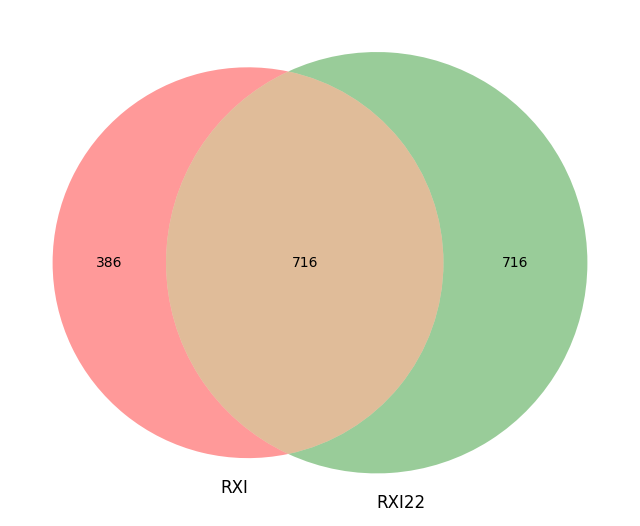

In [33]:
# 'seq_id_position'을 기준으로 두 데이터프레임을 합침
merged_df = pd.merge(df1, df2, on='seq_id_position', how='outer')

# 벤 다이어그램을 그리기 위한 데이터 추출
set1 = set(df1['seq_id_position'])
set2 = set(df2['seq_id_position'])
venn_values = (len(set1 - set2), len(set1 & set2), len(set2 - set1))

# 벤 다이어그램 그리기
venn_labels = {'100': f"{venn_values[0]}",
               '010': f"{venn_values[2]}",
               '001': f"{venn_values[1]}"}

plt.figure(figsize=(8, 8))
venn = venn2(subsets=(len(set1 - set2), len(set2 - set1), len(set1 & set2)),
                 set_labels=('RXI', 'RXI22'))
venn.get_label_by_id('01').set_text(venn_labels['001'])

#plt.title("Venn Diagram of DF1 and DF2")
plt.savefig('YXI.jpg', format = 'jpeg')
plt.show()

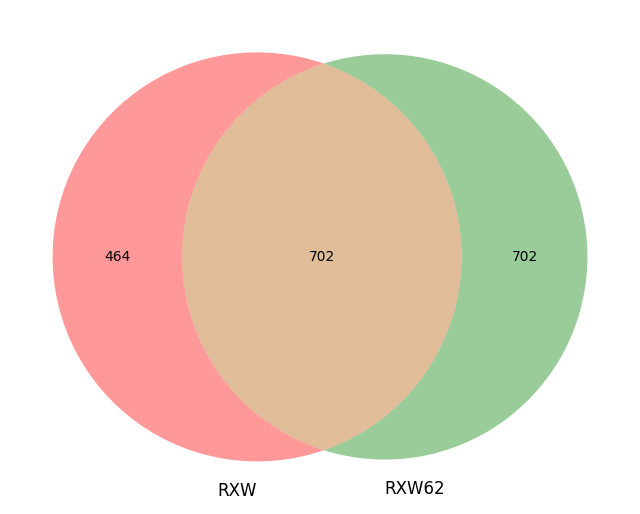

In [34]:
# 'seq_id_position'을 기준으로 두 데이터프레임을 합침
merged_df = pd.merge(df3, df4, on='seq_id_position', how='outer')

# 벤 다이어그램을 그리기 위한 데이터 추출
set3 = set(df3['seq_id_position'])
set4 = set(df4['seq_id_position'])
venn_values = (len(set3 - set4), len(set3 & set4), len(set4 - set3))

# 벤 다이어그램 그리기
venn_labels = {'100': f"{venn_values[0]}",
               '010': f"{venn_values[2]}",
               '001': f"{venn_values[1]}"}

plt.figure(figsize=(8, 8))
venn = venn2(subsets=(len(set3 - set4), len(set4 - set3), len(set3 & set4)),
                 set_labels=('RXW', 'RXW62'))
venn.get_label_by_id('01').set_text(venn_labels['001'])

#plt.title("Venn Diagram of DF3 and DF4")

plt.savefig('YXW.jpg', format = 'jpeg')
plt.show()

In [36]:
#더 예쁜 그림을 원하면 https://bioinformatics.psb.ugent.be/webtools/Venn/ 사용 리스트에 필요한 경우 실행
#excel_file = "Raw.xlsx" # 빈 엑셀 파일 하나 이름 정해 넣을 것
#with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
#    df1.to_excel(writer, sheet_name='RXI_raw', index=False)
#    df2.to_excel(writer, sheet_name='RXI22_raw', index=False)
#    df3.to_excel(writer, sheet_name='RXW_raw', index=False)
#    df4.to_excel(writer, sheet_name='RXW62_raw', index=False)